In [1]:
import numpy as np
import torch
from graph_traffic.train_gnn import test_model, predict
import matplotlib.pyplot as plt
import pandas as pd
from graph_traffic.config import training_path
from graph_traffic.model_selection import get_node_ids
from graph_traffic.get_data import ubs_index
from sklearn.metrics import mean_squared_error, mean_absolute_error

months = ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ids_list = get_node_ids()
_, ubs_dict = ubs_index(ids_list)

df = pd.read_csv(f"{training_path}/gnn-results.csv", sep=";", usecols=["nombre", "evaluate_in", "seq_len", "epoch_selected", "config"])

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
maes = dict()
mses = dict()
for config in range(1, 6):
    print("config", config)
    maes[config] = dict()
    mses[config] = dict()
    for seq_len in [2, 4, 8, 16]:
        print("seq len", seq_len)
        maes[config][seq_len] = dict()
        mses[config][seq_len] = dict()
        for evaluate_in in months:
            print("evaluate month", evaluate_in, end="\r")
            maes[config][seq_len][evaluate_in] = dict()
            mses[config][seq_len][evaluate_in] = dict()
            for i in ids_list:
                maes[config][seq_len][evaluate_in][i] = []
                mses[config][seq_len][evaluate_in][i] = []
            row = df.loc[(df.evaluate_in==evaluate_in) & (df.seq_len==seq_len) & (df.config==config)].iloc[0]
            if np.isnan(row["epoch_selected"]):
                continue
            model_name = row["nombre"]
            epoch = int(row["epoch_selected"])
            model, test_loader, norm_layer, batch_size, graph = test_model(model_name, epoch=epoch)
            for x, y in test_loader:
                all = np.concatenate([x, y], axis=1)[..., 0]
                _, pred = predict(x, y, batch_size, graph, model, torch.device('cpu'), norm_layer)
                y = y[..., 0].detach().numpy()
                #y_modif = y_modif[:, :y.shape[0]*37, 0]
                pred = pred.detach().numpy()[:, :y.shape[0]*37, 0]
                pred = pred.reshape(-1, pred.shape[0], 37)
                for i in ids_list:
                    graph_id = ubs_dict[i]
                    pred_i = pred[:, :, graph_id]
                    y_i = y[:, :, graph_id]
                    maes[config][seq_len][evaluate_in][i].append(mean_absolute_error(pred_i, y_i))
                    mses[config][seq_len][evaluate_in][i].append(mean_squared_error(pred_i, y_i))

config 1
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 2 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 3 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 4 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 5 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec


In [19]:
def get_mean(l):
    if len(l) == 0:
        return np.nan
    else:
        return np.nanmean(l)

In [20]:
for config in range(1, 6):
    for seq_len in [2, 4, 8, 16]:
        maes_df = pd.DataFrame(maes[config][seq_len]).applymap(get_mean).sort_index()
        maes_df["avg"] = maes_df.loc[:, :"Dec"].mean(axis=1)
        maes_df["std"] = maes_df.loc[:, :"Dec"].std(axis=1)
        maes_df.round(4).to_csv(f"{training_path}/gnn/config{config}/maes_{seq_len}.csv")

In [21]:
for config in range(1, 6):
    for seq_len in [2, 4, 8, 16]:
        mses_df = pd.DataFrame(mses[config][seq_len]).applymap(get_mean).sort_index()
        mses_df["avg"] = mses_df.loc[:, :"Dec"].mean(axis=1)
        mses_df["std"] = mses_df.loc[:, :"Dec"].std(axis=1)
        mses_df.round(4).to_csv(f"{training_path}/gnn/config{config}/mses_{seq_len}.csv")

In [ ]:
plt.plot(all[0, :, 0, 0])
plt.plot(range(16, 32), pred.detach().numpy()[:, 0])

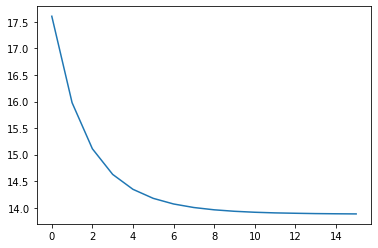

In [120]:
plt.plot(pred.detach().numpy()[:, 0, 0])

In [ ]:
(2, 32, 37, 1)

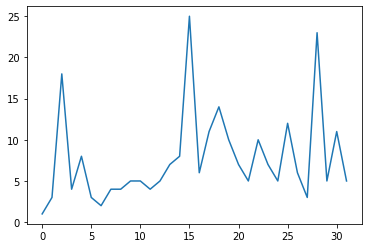

In [113]:
plt.plot(all[0, :, 0, 0])

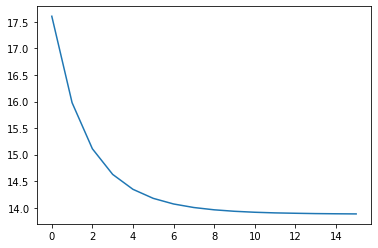

In [105]:
plt.plot(pred.detach().numpy()[:, 0])

In [26]:
import pickle
with open(rf"C:\Users\Bened\PycharmProjects\madrid-traffic\training_history\{training_datetime}\losses\train.pkl", "rb") as f:
    train = pickle.load(f)
train

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Bened\\PycharmProjects\\madrid-traffic\\training_history\\20220609_202835\\losses\\train.pkl'

In [ ]:
import pickle
with open(fr"C:\Users\Bened\PycharmProjects\madrid-traffic\training_history\{training_datetime}\losses\test.pkl", "rb") as f:
    test = pickle.load(f)
test